# G16 Code for creating demo data

## 0. Load data

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
print(sys.prefix)

/opt/anaconda3/envs/school_as


In [3]:
# import data
dir = '../data/raw/'
filename = 'BMMS_overview.xlsx'
df_bridges = pd.read_excel(dir + filename)

In [4]:
#df_bridges.head()

In [5]:
# import data
dir = '../data/raw/'
filename = '_roads3.csv' # replace this with the interpolated data
df_roads = pd.read_csv(dir + filename)

In [6]:
#df_roads.head()

In [7]:
# print shape of dataframes
print(df_bridges.shape)
print(df_roads.shape)

(20415, 20)
(51348, 8)


## 1. Remove duplicates from BMMS_overview.xlsx

In [8]:
df_bridges_clean = df_bridges.copy()
df_bridges_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20415 entries, 0 to 20414
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   road              20415 non-null  object 
 1   km                20415 non-null  float64
 2   type              20415 non-null  object 
 3   LRPName           20415 non-null  object 
 4   name              20100 non-null  object 
 5   length            20406 non-null  float64
 6   condition         20415 non-null  object 
 7   structureNr       20415 non-null  int64  
 8   roadName          20415 non-null  object 
 9   chainage          20415 non-null  float64
 10  width             17408 non-null  float64
 11  constructionYear  17407 non-null  float64
 12  spans             17408 non-null  float64
 13  zone              20415 non-null  object 
 14  circle            20415 non-null  object 
 15  division          20415 non-null  object 
 16  sub-division      20415 non-null  object

In [9]:
# add a new colum 'road_lrp' combines 'road' and 'lrp'
df_bridges_clean['road_lrp'] = df_bridges_clean['road'] + df_bridges_clean['LRPName']

# add a new column 'name_clean' equals to 'name' 
df_bridges_clean['name_clean'] = df_bridges_clean['name']

# add a new column 'road_chainage' equals to 'chainage', but turn float into string, combine 'road' and 'chainage'
df_bridges_clean['road_chainage'] = df_bridges_clean['chainage'].astype(str)
df_bridges_clean['road_chainage'] = df_bridges_clean['road'] + df_bridges_clean['road_chainage']


In [10]:

#df_bridges_clean.head()

In [11]:
# lower the letters 
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.lower()

# delet space 
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.replace(' ', '')

# delet hypen
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.replace('-', '')

# delet comma
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.replace(',', '')

# mark the unknown road name
df_bridges_clean.loc[df_bridges_clean['name_clean'] == '.', 'name_clean'] = 'unknown'

# delet period 
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.replace('.', '')

In [12]:
df_bridges_clean.shape

(20415, 23)

In [13]:
# delete duplicate in both 'road_lrp' and 'road_chainage' columns
df_bridges_clean = df_bridges_clean.drop_duplicates(subset=['road_lrp','chainage'], keep='first')
df_bridges_clean.shape

(17518, 23)

In [14]:
# replace (r) with (right), (l) with (left) in column 'name_clean'
df_bridges_clean.loc[:, 'name_clean'] = df_bridges_clean['name_clean'].str.replace('right', 'r')
df_bridges_clean.loc[:, 'name_clean'] = df_bridges_clean['name_clean'].str.replace('left', 'l')

In [15]:
# find the duplicated value in 'road_chainage' column, show the unique values in 'name_clean' column
df_bridges_clean[df_bridges_clean.duplicated(subset=['road_chainage'], keep=False)].sort_values(by='road_chainage').name_clean.unique()

array(['darikandibridge(r)', 'darikandibridge(l)', 'sonakhalbridge(l)',
       'sonakhalbridge(r)', 'mollikparabridge(r)', 'marikhalibridge(r)',
       'marikhalibridge(l)', 'ashariarcharbridge(r)', 'ashirchar(r)',
       'asharirchar2bridge(r)', 'ashariachar2bridge(l)',
       'bhatercharbridge(l)', 'bhatercharbridge(r)', 'anarparabridge(l)',
       'anarparabridge(r)', 'bhabercharbridge(r)', 'bhabercharbridge(l)',
       'baushiabridge(r)', 'baushiabridge(l)', 'madhyabaushiabridge(l)',
       'madhyabaushiabridge(r)', 'baushiabazarbridge(l)',
       'baushiabazarbridge(r)', 'bridgeoverturagriver(r)',
       'salehpurbridge(r)', 'fulbariabridge(l)', 'fulbariabridge(r)',
       'zadircharbridge(r)', 'zadircharbridge(l)', 'jorpulbridge(r)',
       'jorpurbridge(l)', 'dhalapara', 'dobukay', 'kamarkhalbridge',
       'unknown', 'dabagrambridge', 'lalbaribridge', 'tairmukhbridge',
       'ghonurambridge', 'naudabosbridge', 'sambordbridge'], dtype=object)

In [16]:
# Function to filter bridges based on left or right (keep left bridge), and conditions (keep worse condition)
def filter_bridges(df):
    df = df.copy()
    
    # Condition priority (higher = worse condition)
    condition_priority = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
    df['condition_priority'] = df['condition'].map(condition_priority)

    # Group by 'chainage'
    grouped = df.groupby('road_chainage')

    rows_to_keep = []

    for _, group in grouped:
        if len(group) == 1:  # If only one row exists for this chainage, keep it
            rows_to_keep.append(group.index[0])
            continue

        # Identify left and right bridges
        left_bridge = group[group['name_clean'].str.contains('(l)', na=False, regex=False)]
        right_bridge = group[group['name_clean'].str.contains('(r)', na=False, regex=False)]

        if not left_bridge.empty and not right_bridge.empty:
            # If both left and right exist, keep only the left bridge
            rows_to_keep.append(left_bridge.index[0])
        else: 
            # If two (r) or two (l) exist, or none of them exist, keep the one with the worst condition
            worst_bridge = group.sort_values(by='condition_priority', ascending=False).iloc[0]
            rows_to_keep.append(worst_bridge.name)

    # Keep only selected rows
    return df.loc[rows_to_keep].drop(columns=['condition_priority']).reset_index(drop=True)



In [17]:
# Apply function
df_bridges_clean = filter_bridges(df_bridges_clean)
df_bridges_clean.shape

(17494, 23)

In [18]:
# check the duplicated value in 'chainage' column
df_bridges_clean[df_bridges_clean.duplicated(subset=['road_chainage'], keep=False)].sort_values(by=['road_lrp'])

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,zone,circle,division,sub-division,lat,lon,EstimatedLoc,road_lrp,name_clean,road_chainage


In [19]:
df_bridges_clean.head(3)

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,zone,circle,division,sub-division,lat,lon,EstimatedLoc,road_lrp,name_clean,road_chainage
0,N102,0.984,Box Culvert,LRPSc,PORISPUR BOX CULVERT,3.0,A,101312,Comilla (Mainamati)-Brahmanbaria (Sarail) Road,0.984,...,Comilla,Comilla,Comilla,Gouripur,23.486582,91.113418,interpolate,N102LRPSc,porispurboxculvert,N1020.984
1,N102,10.530,Slab Culvert,LRP010c,CONSUNAGAR SLAB,0.9,A,108189,Comilla (Mainamati)-Brahmanbaria (Sarail) Road,10.530,...,Comilla,Comilla,Comilla,Gouripur,23.555582,91.061578,interpolate,N102LRP010c,consunagarslab,N10210.53
2,N102,11.876,Box Culvert,LRP011a,HATAMARA BOX CULVERT.,3.2,A,101290,Comilla (Mainamati)-Brahmanbaria (Sarail) Road,11.876,...,Comilla,Comilla,Comilla,Gouripur,23.560419,91.055519,interpolate,N102LRP011a,hatamaraboxculvert,N10211.876


## 2. Remove duplicates from _roads3.csv

In [20]:
df_roads_clean = df_roads.copy()
df_roads_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51348 entries, 0 to 51347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   road      51348 non-null  object 
 1   chainage  51348 non-null  float64
 2   lrp       51348 non-null  object 
 3   lat       51348 non-null  float64
 4   lon       51348 non-null  float64
 5   gap       9074 non-null   object 
 6   type      51348 non-null  object 
 7   name      51348 non-null  object 
dtypes: float64(3), object(5)
memory usage: 3.1+ MB


In [21]:
# add a new column 'road_chainage' equals to 'chainage', but turn float into string, combine 'road' and 'chainage'
df_roads_clean['road_chainage'] = df_roads_clean['chainage'].astype(str)
df_roads_clean['road_chainage'] = df_roads_clean['road'] + df_roads_clean['road_chainage']

# add a new colum 'road_lrp' combines 'road' and 'lrp'
df_roads_clean['road_lrp'] = df_roads_clean['road'] + df_roads_clean['lrp']


In [22]:
#df_roads_clean.head()

In [23]:
# find the duplicated value in 'road_lrp' column
df_roads_clean[df_roads_clean.duplicated(subset=['road_lrp'], keep=False)].sort_values(by='road_lrp')


,road,chainage,lrp,lat,lon,gap,type,name,road_chainage,road_lrp
27331,Z2002,28.005,LRPE,24.358056,91.962778,NaN,KmPost,Km post missing,Z200228.005,Z2002LRPE
27347,Z2002,33.089,LRPE,24.322944,91.995861,NaN,Others,Road end at Chatla Cheek Post,Z200233.089,Z2002LRPE
50500,Z8740,3.315,LRP003c,22.424666,90.090389,BS,Bridge,Baily Bridge start,Z87403.315,Z8740LRP003c
50498,Z8740,3.276,LRP003c,22.424694,90.090389,BS,Bridge,baily brije start,Z87403.276,Z8740LRP003c
50501,Z8740,3.327,LRP003d,22.424860,90.090305,BE,Bridge,Baily Bridge end,Z87403.327,Z8740LRP003d
50499,Z8740,3.288,LRP003d,22.424860,90.090305,BE,Bridge,baily brije end,Z87403.288,Z8740LRP003d
50511,Z8740,5.111,LRP005a,22.429305,90.074749,BS,Bridge,brije start,Z87405.111,Z8740LRP005a
50513,Z8740,5.141,LRP005a,22.429305,90.074749,BS,Bridge,Bridge start,Z87405.141,Z8740LRP005a
50512,Z8740,5.133,LRP005b,22.429249,90.074527,BE,Bridge,brije end,Z87405.133,Z8740LRP005b
50514,Z8740,5.163,LRP005b,22.429249,90.074527,BE,Bridge,Bridge end,Z87405.163,Z8740LRP005b


In [24]:
# check rows between index 27330 and 27347
df_roads_clean.loc[27330:27347]


,road,chainage,lrp,lat,lon,gap,type,name,road_chainage,road_lrp
27330,Z2002,27.645,LRP027c,24.361056,91.961000,NaN,Culvert,Box culvert,Z200227.645,Z2002LRP027c
27331,Z2002,28.005,LRPE,24.358056,91.962778,NaN,KmPost,Km post missing,Z200228.005,Z2002LRPE
27332,Z2002,29.005,LRP029,24.351472,91.969583,NaN,KmPost,Km post missing,Z200229.005,Z2002LRP029
27333,Z2002,29.027,LRP029a,24.351333,91.969694,NaN,Culvert,Box culvert,Z200229.027,Z2002LRP029a
27334,Z2002,29.509,LRP029b,24.348666,91.973416,NaN,Culvert,Box culvert,Z200229.509,Z2002LRP029b
27335,Z2002,29.880,LRP029c,24.346333,91.975972,NaN,Culvert,Box culvert,Z200229.88,Z2002LRP029c
27336,Z2002,29.975,LRP030,24.345611,91.976499,NaN,KmPost,Information missing,Z200229.975,Z2002LRP030
27337,Z2002,30.342,LRP030a,24.340055,91.978388,NaN,Culvert,Box culvert,Z200230.342,Z2002LRP030a
27338,Z2002,30.975,LRP031,24.337944,91.981694,NaN,KmPost,Information missing,Z200230.975,Z2002LRP031
27339,Z2002,30.983,LRP031a,24.337916,91.981722,NaN,Culvert,Box culvert,Z200230.983,Z2002LRP031a


In [25]:
# manually change the lrp in row 27331 to 'LRP028', road_lrp to 'Z2002LRP028'
df_roads_clean.loc[27331, 'lrp'] = 'LRP028'
df_roads_clean.loc[27331, 'road_lrp'] = 'Z2002LRP028'

In [26]:
# clean the duplicated road_lrp, as all the bridge information come from BMMW_overview.xlsx
df_roads_clean = df_roads_clean.drop_duplicates(subset=['road_lrp'], keep='first')

In [27]:
# check the duplicated value in 'road_lrp' column
df_roads_clean[df_roads_clean.duplicated(subset=['road_lrp'], keep=False)].sort_values(by='road_lrp')

,road,chainage,lrp,lat,lon,gap,type,name,road_chainage,road_lrp


## 3. Combine data from BMMS_overview.xlsx & _roads3.csv

In [28]:
# change the column names of the bridges dataframe: LRPName -> lrp
df_bridges_clean.rename(columns={'LRPName': 'lrp'}, inplace=True)


In [29]:
# add a column named 'model_type' to the df_bridges dataframe and fill it with 'bridge'
df_bridges_clean['model_type'] = 'bridge'

# add a column named 'model_type' to the df_roads dataframe and fill it with 'link';
# but if the last character in the column 'lrp' isn't number, fill it with 'bridge', except for 'S' and 'E'
df_roads_clean['model_type'] = 'link'
df_roads_clean.loc[df_roads['lrp'].str[-1].str.isnumeric() == False, 'model_type'] = 'bridge'
df_roads_clean.loc[df_roads['lrp'].str[-1] == 'S', 'model_type'] = 'link'
df_roads_clean.loc[df_roads['lrp'].str[-1] == 'E', 'model_type'] = 'link'


In [30]:
#df_roads

In [31]:
# make a copy of the df_bridges dataframe and name it df_bridges_original
df_bridges_original = df_bridges_clean.copy()

# merge the df_bridges and df_roads dataframes
df_concat = pd.concat([df_bridges_clean, df_roads_clean])

In [32]:
#df_concat.head()

In [33]:
# sort the df_concat dataframe, groupedby 'road', by 'chainage'
df_concat = df_concat.sort_values(by=['road', 'chainage'])

In [34]:
#df_concat.head()

## 4. Build the demo dataframe w/ 'sourcesink'

In [35]:
# if the 'model_type' is 'bridge' and the 'condition' is NaN, drop the row; Keep the rows with 'model_type' as 'link'
df_concat = df_concat[~((df_concat['model_type'] == 'bridge') & (df_concat['condition'].isna())) | (df_concat['model_type'] == 'link')]

In [36]:
# Initialize an empty list to store the rows of the new DataFrame
new_rows = []

# Iterate over each unique road in df_concat
for road in df_concat['road'].unique():
    road_rows = df_concat[df_concat['road'] == road].reset_index(drop=True)
    for i, row in road_rows.iterrows():
        if i == 0:
            model_type = 'sourcesink'
        elif i == len(road_rows) - 1:
            model_type = 'sourcesink'
        else:
            model_type = row['model_type']
        
        length = 0 if i == 0 else row['chainage'] - road_rows.loc[i-1, 'chainage']
        new_row = {
            'road': row['road'],
            'id': f"{row['road']}_{i}",
            'model_type': model_type,
            'name': row['name'],
            'lat': row['lat'],
            'lon': row['lon'],
            'length': length,
            'condition': row['condition'],
            'road_lrp': row['road_lrp']
        }
        new_rows.append(new_row)

# Convert the list to a DataFrame
df_all_roads = pd.DataFrame(new_rows)

In [37]:
df_all_roads[(df_all_roads['road'] == 'N1') | (df_all_roads['road'] == 'N2')]

,road,id,model_type,name,lat,lon,length,condition,road_lrp
0,N1,N1_0,sourcesink,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.000,NaN,N1LRPS
1,N1,N1_1,link,Km post missing,23.702139,90.451972,1.000,NaN,N1LRP001
2,N1,N1_2,bridge,.,23.698739,90.458861,0.800,A,N1LRP001a
3,N1,N1_3,link,Km post missing,23.697889,90.460583,0.200,NaN,N1LRP002
4,N1,N1_4,link,Km post missing,23.693833,90.469138,1.000,NaN,N1LRP003
...,...,...,...,...,...,...,...,...,...
2564,N2,N2_747,bridge,.,25.171993,92.020065,0.347,A,N2LRP285b
2565,N2,N2_748,bridge,.,25.171049,92.018726,0.180,A,N2LRP285c
2566,N2,N2_749,link,Km post broken,25.170055,92.016389,0.298,NaN,N2LRP286
2567,N2,N2_750,link,Jaflong 1 km,25.162889,92.017110,1.000,NaN,N2LRP287


## 6. Filter only N1, N2, and their side roads (N1xx, N2xx) that are longer than 25 km

In [38]:
# Filter the dataframe to include only roads N1, N2, and their side roads (N1xx, N2xx)
df_filtered = df_all_roads[df_all_roads['road'].str.match(r'^(N1|N2)\d*$')]

# Display the filtered dataframe
df_filtered

,road,id,model_type,name,lat,lon,length,condition,road_lrp
0,N1,N1_0,sourcesink,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.000,NaN,N1LRPS
1,N1,N1_1,link,Km post missing,23.702139,90.451972,1.000,NaN,N1LRP001
2,N1,N1_2,bridge,.,23.698739,90.458861,0.800,A,N1LRP001a
3,N1,N1_3,link,Km post missing,23.697889,90.460583,0.200,NaN,N1LRP002
4,N1,N1_4,link,Km post missing,23.693833,90.469138,1.000,NaN,N1LRP003
...,...,...,...,...,...,...,...,...,...
2954,N210,N210_8,link,Dhaka 248 Km,24.857861,91.927638,1.100,NaN,N210LRP008
2955,N210,N210_9,link,Dhaka 247 Km,24.849916,91.922916,1.000,NaN,N210LRP009
2956,N210,N210_10,link,Dhaka 246 Km,24.846833,91.914028,1.000,NaN,N210LRP010
2957,N210,N210_11,link,Dhaka 245 Km,24.847472,91.904167,1.000,NaN,N210LRP011


In [39]:
# print the shape of the filtered dataframe
df_filtered.shape

(2959, 9)

In [40]:
# print unique values in 'road' column
df_filtered['road'].unique()

array(['N1', 'N101', 'N102', 'N103', 'N104', 'N105', 'N106', 'N107',
       'N108', 'N109', 'N110', 'N111', 'N112', 'N119', 'N120', 'N123',
       'N128', 'N129', 'N2', 'N203', 'N204', 'N205', 'N206', 'N207',
       'N208', 'N209', 'N210'], dtype=object)

In [41]:
# count model_type == 'sourcesink' in the filtered dataframe
df_filtered['model_type'].value_counts()

model_type
bridge        1641
link          1264
sourcesink      54
Name: count, dtype: int64

In [42]:
df_filtered.groupby('road')['length'].sum()

road
N1      462.254
N101      6.021
N102     82.682
N103      4.779
N104     49.630
N105     48.870
N106     66.850
N107     10.542
N108     22.541
N109      2.510
N110      7.560
N111     12.660
N112      2.720
N119      2.000
N120     20.940
N123      8.060
N128      1.297
N129      2.790
N2      286.516
N203      0.975
N204     34.421
N205      2.478
N206      1.797
N207     67.985
N208     57.495
N209      1.330
N210     10.844
Name: length, dtype: float64

In [43]:
(df_filtered.groupby('road')['length'].sum() > 25).sum()

9

In [44]:
# filter df_filtered.groupby('road')['length'].sum() > 25
df_filtered_25 = df_filtered[df_filtered.groupby('road')['length'].transform('sum') > 25]

In [45]:
df_filtered_25.groupby('road')['length'].sum()

road
N1      462.254
N102     82.682
N104     49.630
N105     48.870
N106     66.850
N2      286.516
N204     34.421
N207     67.985
N208     57.495
Name: length, dtype: float64

In [46]:
df_filtered_25.head(3)

,road,id,model_type,name,lat,lon,length,condition,road_lrp
0,N1,N1_0,sourcesink,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.0,NaN,N1LRPS
1,N1,N1_1,link,Km post missing,23.702139,90.451972,1.0,NaN,N1LRP001
2,N1,N1_2,bridge,.,23.698739,90.458861,0.8,A,N1LRP001a


In [47]:
df_filtered_25.shape

(2728, 9)

In [48]:
# check whether there's any 'intersection' in the 'name' column
df_filtered_25[df_filtered_25['name'].str.contains('intersection', na=False, case=False)]

,road,id,model_type,name,lat,lon,length,condition,road_lrp
1276,N104,N104_0,sourcesink,Intersection with Z1031,23.009667,91.399416,0.000,NaN,N104LRPS
1459,N105,N105_92,sourcesink,"B.Bridge 83 km,Tangail 60 km / End of Road In...",23.989527,90.358222,2.011,NaN,N105LRP048
2940,N208,N208_149,sourcesink,"Road end at Humayun Rashid Chattar, Intersecti...",24.877555,91.875360,0.406,NaN,N208LRPE


## 7. Define intersections

In [49]:
# haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance # in kilometers

In [50]:
# for every 'id' in a 'road', find the nearest other 'road's 'id' and the distance between them
def find_nearest_roads(df):
    df = df.copy()
    df['nearest_road'] = np.nan
    df['distance_to_nearest_road'] = np.nan

    for i, row in df.iterrows():
        lat1, lon1 = row['lat'], row['lon']
        road = row['road']
        other_roads = df.drop(index=i)
        other_roads = other_roads[other_roads['road'] != road]  # exclude rows with the same 'road'
        distances = other_roads.apply(lambda x: haversine(lat1, lon1, x['lat'], x['lon']), axis=1)
        nearest_road = other_roads.loc[distances.idxmin(), 'id']
        distance_to_nearest_road = distances.min()
        df.loc[i, 'nearest_road'] = nearest_road
        df.loc[i, 'distance_to_nearest_road'] = distance_to_nearest_road

    return df

In [51]:
# choose only model_type == link
df_filtered_25_links = df_filtered_25[df_filtered_25['model_type'] == 'link']

In [52]:
df_1 = find_nearest_roads(df_filtered_25_links)

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_5426/518213464.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'N2_4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'nearest_road'] = nearest_road


In [53]:
df_1

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1,N1,N1_1,link,Km post missing,23.702139,90.451972,1.000,NaN,N1LRP001,N2_4,6.721600
3,N1,N1_3,link,Km post missing,23.697889,90.460583,0.200,NaN,N1LRP002,N2_2,6.039555
4,N1,N1_4,link,Km post missing,23.693833,90.469138,1.000,NaN,N1LRP003,N2_2,5.403044
5,N1,N1_5,link,Km post missing,23.693611,90.478777,1.000,NaN,N1LRP004,N2_1,4.494627
7,N1,N1_7,link,Km post missing,23.694750,90.488500,0.075,NaN,N1LRP005,N2_1,3.524024
...,...,...,...,...,...,...,...,...,...,...,...
2933,N208,N208_142,link,Sylhet 7 km,24.842555,91.895583,1.000,NaN,N208LRP054,N2_617,4.372308
2934,N208,N208_143,link,Sylhet 8 km,24.849527,91.894916,0.920,NaN,N208LRP055,N2_621,3.704796
2935,N208,N208_144,link,Sylhet 7 km,24.855778,91.888111,1.000,NaN,N208LRP056,N2_621,2.760932
2937,N208,N208_146,link,Sylhet 6 km,24.861889,91.881027,0.555,NaN,N208LRP057,N2_617,1.834244


In [54]:
# ascencding order by distance_to_nearest_road
df_intersection = df_1.sort_values(by='distance_to_nearest_road').head(50)

sensitive to the head(n) 

In [55]:
df_intersection

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1818,N2,N2_1,link,Sylhet 230 km,23.706889,90.520472,0.166,NaN,N2LRP001,N1_11,0.237216
11,N1,N1_11,link,"Chittagong 251 km,Comilla 84 km",23.705028,90.519333,0.503,NaN,N1LRP009,N2_1,0.237216
2166,N2,N2_349,link,Sylhet 90 km,24.267249,91.474360,0.227,NaN,N2LRP142,N204_67,0.363083
2638,N204,N204_67,link,Km post missing,24.266556,91.477860,0.710,NaN,N204LRP036,N2_349,0.363083
1280,N104,N104_4,link,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
265,N1,N1_265,link,Km post missing,23.013278,91.376944,1.000,NaN,N1LRP148,N104_4,0.544195
1386,N105,N105_19,link,Information missing,23.789222,90.568805,1.021,NaN,N105LRP013,N2_13,0.550613
1830,N2,N2_13,link,Km post missing,23.784972,90.566028,1.000,NaN,N2LRP012,N105_19,0.550613
1833,N2,N2_16,link,Km post broken,23.789250,90.574277,0.031,NaN,N2LRP013,N105_19,0.556790
1385,N105,N105_18,link,"Bangabondhu Bridge 118 km, Mymenshingh 151 km,...",23.780555,90.570055,1.044,NaN,N105LRP012,N2_13,0.639637


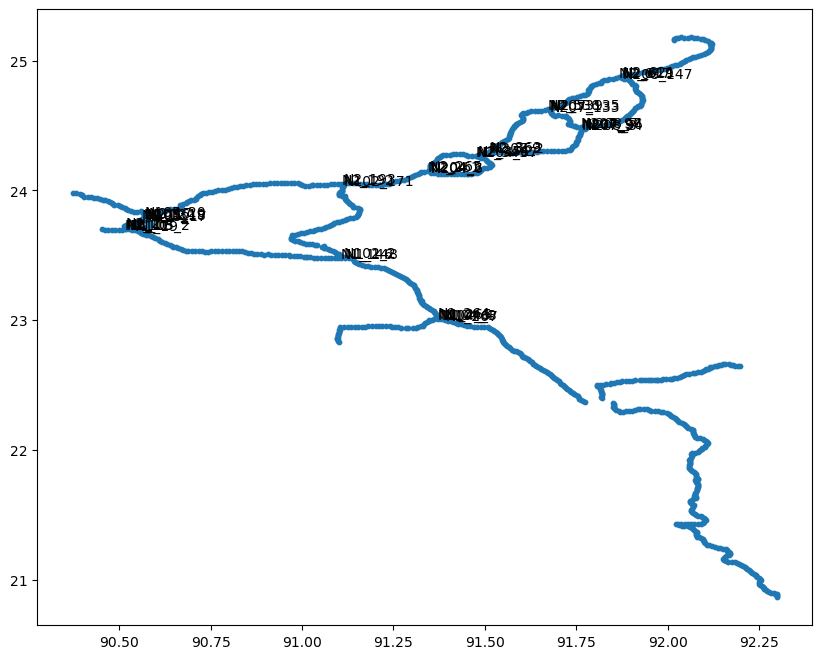

In [56]:
plt.figure(figsize=(10, 8))

plt.scatter(df_1['lon'], df_1['lat'], s=10)
for i, row in df_1.iterrows():
    if row['id'] in df_intersection['id'].values:
        plt.text(row['lon'], row['lat'], row['id'], fontsize=10)
plt.show()

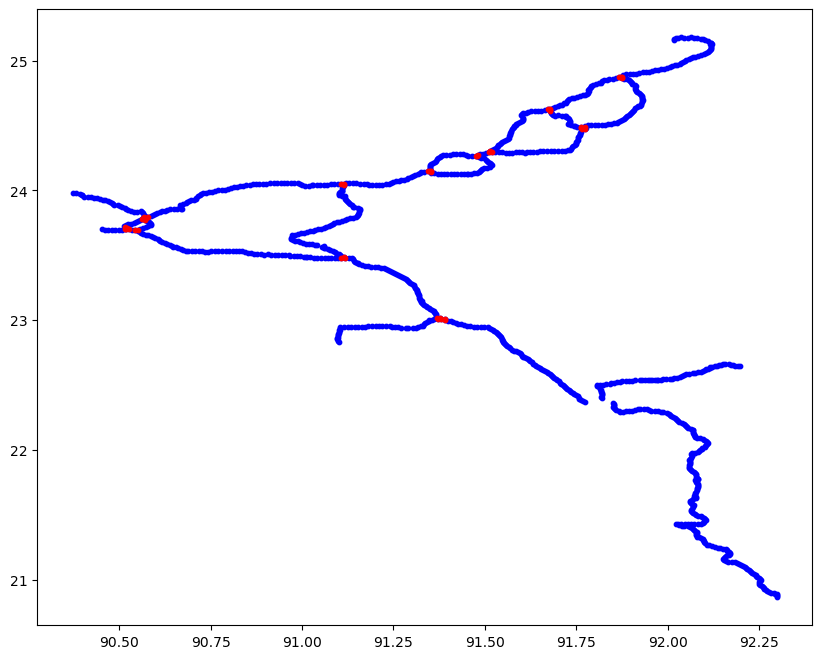

In [57]:
# plot the whole road but assign different color to df_intersection
plt.figure(figsize=(10, 8))

plt.scatter(df_1['lon'], df_1['lat'], s=10, c='blue')
plt.scatter(df_intersection['lon'], df_intersection['lat'], s=10, c='red')

plt.show()


1. Duplicates appear 
2. N1 and N106 is not connected: special case that needs to be addressed seperately

In [58]:
# find_nearest_roads function between specific 2 roads
def find_nearest_roads_2(df, road1, road2):
    df = df.copy()
    df['nearest_road'] = np.nan
    df['distance_to_nearest_road'] = np.nan

    for i, row in df.iterrows():
        lat1, lon1 = row['lat'], row['lon']
        road = row['road']
        if road == road1:
            other_roads = df[df['road'] == road2]
        elif road == road2:
            other_roads = df[df['road'] == road1]
        else:
            continue
        distances = other_roads.apply(lambda x: haversine(lat1, lon1, x['lat'], x['lon']), axis=1)
        nearest_road = other_roads.loc[distances.idxmin(), 'id']
        distance_to_nearest_road = distances.min()
        df.loc[i, 'nearest_road'] = nearest_road
        df.loc[i, 'distance_to_nearest_road'] = distance_to_nearest_road

    return df

In [59]:
df_N1_N106 = find_nearest_roads_2(df_filtered_25_links, 'N1', 'N106')

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_5426/1136000136.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'N106_31' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'nearest_road'] = nearest_road


In [60]:
N1_N106 = df_N1_N106.sort_values(by='distance_to_nearest_road').head(2)

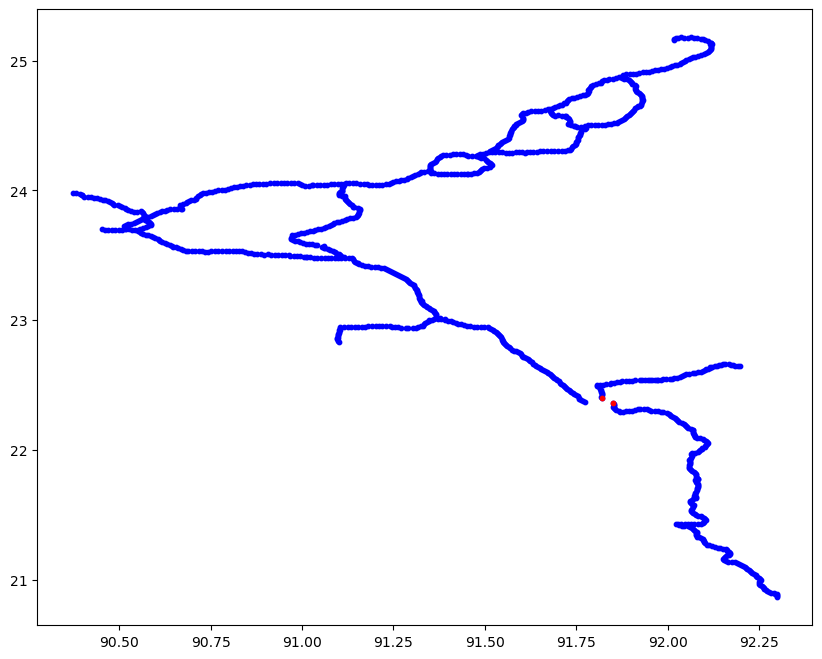

In [61]:
plt.figure(figsize=(10, 8))

plt.scatter(df_1['lon'], df_1['lat'], s=10, c='blue')
plt.scatter(N1_N106['lon'], N1_N106['lat'], s=10, c='red')

plt.show()

In [64]:
N1_N106

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1464,N106,N106_4,link,Km post missing,22.402056,91.819110,0.182,NaN,N106LRP001,N1_445,5.289073
445,N1,N1_445,link,Km post missing,22.364611,91.850833,9.450,NaN,N1LRP245,N106_4,5.289073


In [65]:
# merge N1_N106 to df_intersection
df_intersection_1 = pd.concat([df_intersection, N1_N106])

In [66]:
df_intersection_1.shape

(52, 11)

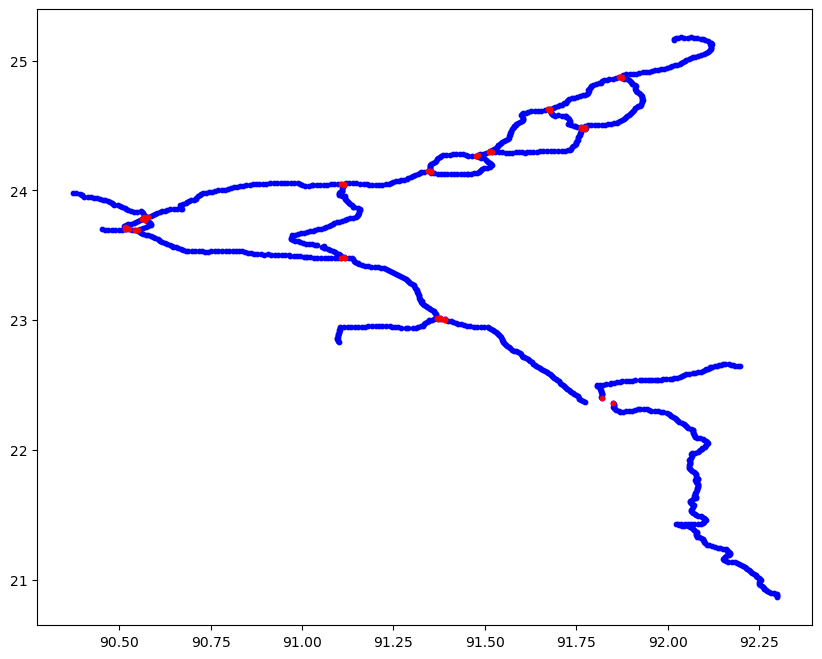

In [67]:
plt.figure(figsize=(10, 8))

plt.scatter(df_1['lon'], df_1['lat'], s=10, c='blue')
plt.scatter(df_intersection_1['lon'], df_intersection_1['lat'], s=10, c='red')

plt.show()

In [68]:
df_intersection_1

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1818,N2,N2_1,link,Sylhet 230 km,23.706889,90.520472,0.166,NaN,N2LRP001,N1_11,0.237216
11,N1,N1_11,link,"Chittagong 251 km,Comilla 84 km",23.705028,90.519333,0.503,NaN,N1LRP009,N2_1,0.237216
2166,N2,N2_349,link,Sylhet 90 km,24.267249,91.474360,0.227,NaN,N2LRP142,N204_67,0.363083
2638,N204,N204_67,link,Km post missing,24.266556,91.477860,0.710,NaN,N204LRP036,N2_349,0.363083
1280,N104,N104_4,link,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
265,N1,N1_265,link,Km post missing,23.013278,91.376944,1.000,NaN,N1LRP148,N104_4,0.544195
1386,N105,N105_19,link,Information missing,23.789222,90.568805,1.021,NaN,N105LRP013,N2_13,0.550613
1830,N2,N2_13,link,Km post missing,23.784972,90.566028,1.000,NaN,N2LRP012,N105_19,0.550613
1833,N2,N2_16,link,Km post broken,23.789250,90.574277,0.031,NaN,N2LRP013,N105_19,0.556790
1385,N105,N105_18,link,"Bangabondhu Bridge 118 km, Mymenshingh 151 km,...",23.780555,90.570055,1.044,NaN,N105LRP012,N2_13,0.639637


In [69]:
# show rows that have duplicate 'nearest_road' AND 'road'
df_intersection_1[df_intersection_1.duplicated(subset=['nearest_road', 'road'], keep=False)].sort_values(by=['nearest_road', 'road'])

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
2009,N2,N2_192,link,Sylhet 146 km,24.049722,91.107750,0.694,NaN,N2LRP086,N102_171,1.056156
2010,N2,N2_193,link,Km post missing,24.053306,91.114611,1.000,NaN,N2LRP087,N102_171,1.246494
148,N1,N1_148,link,Km post missing,23.478972,91.117999,0.880,NaN,N1LRP084,N102_2,0.985816
146,N1,N1_146,link,Km post missing,23.477999,91.105528,1.000,NaN,N1LRP083,N102_2,1.252970
1830,N2,N2_13,link,Km post missing,23.784972,90.566028,1.000,NaN,N2LRP012,N105_19,0.550613
1833,N2,N2_16,link,Km post broken,23.789250,90.574277,0.031,NaN,N2LRP013,N105_19,0.556790
1818,N2,N2_1,link,Sylhet 230 km,23.706889,90.520472,0.166,NaN,N2LRP001,N1_11,0.237216
1819,N2,N2_2,link,Sylhet 229 km,23.715139,90.516833,1.000,NaN,N2LRP002,N1_11,1.152753
1280,N104,N104_4,link,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
1282,N104,N104_6,link,"Begumgonj 33 km,Maijdee 43 km",23.009444,91.370472,0.370,NaN,N104LRP003,N1_265,0.787705


In [82]:
# if there is duplicate 'nearest_road' AND 'road', keep the one with the smaller 'distance_to_nearest_road'
df_intersection_2 = df_intersection_1.sort_values(by='distance_to_nearest_road').drop_duplicates(subset=['nearest_road','road'], keep='first')

In [83]:
df_intersection_2.shape

(37, 11)

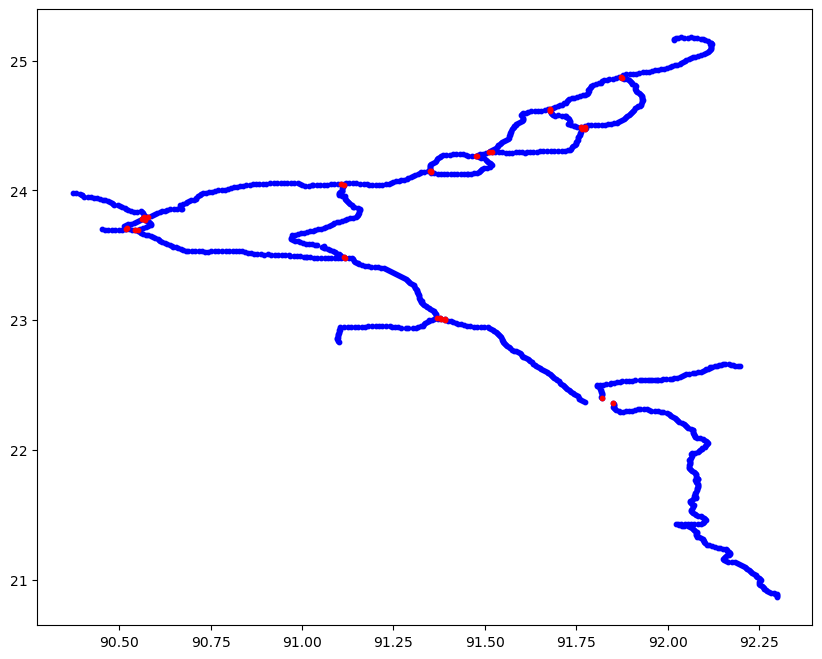

In [84]:
# plot the whole road but assign different color to df_N1_N106
plt.figure(figsize=(10, 8))

plt.scatter(df_1['lon'], df_1['lat'], s=10, c='blue')
plt.scatter(df_intersection_2['lon'], df_intersection_2['lat'], s=10, c='red')

plt.show()

In [85]:
df_intersection_2

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1818,N2,N2_1,link,Sylhet 230 km,23.706889,90.520472,0.166,NaN,N2LRP001,N1_11,0.237216
11,N1,N1_11,link,"Chittagong 251 km,Comilla 84 km",23.705028,90.519333,0.503,NaN,N1LRP009,N2_1,0.237216
2166,N2,N2_349,link,Sylhet 90 km,24.267249,91.474360,0.227,NaN,N2LRP142,N204_67,0.363083
2638,N204,N204_67,link,Km post missing,24.266556,91.477860,0.710,NaN,N204LRP036,N2_349,0.363083
1280,N104,N104_4,link,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
265,N1,N1_265,link,Km post missing,23.013278,91.376944,1.000,NaN,N1LRP148,N104_4,0.544195
1386,N105,N105_19,link,Information missing,23.789222,90.568805,1.021,NaN,N105LRP013,N2_13,0.550613
1830,N2,N2_13,link,Km post missing,23.784972,90.566028,1.000,NaN,N2LRP012,N105_19,0.550613
2789,N207,N207_135,link,Sylhet 38 km,24.623277,91.678166,0.075,NaN,N207LRP068,N2_539,0.640258
2356,N2,N2_539,link,Sylhet 40 km/ Start of Sylhet road Division / ...,24.629027,91.678499,0.020,NaN,N2LRP192,N207_135,0.640258


In [86]:
index = [1829, 264, 2787, 1384, 2577]
df_single_out = df_intersection_2.loc[index]

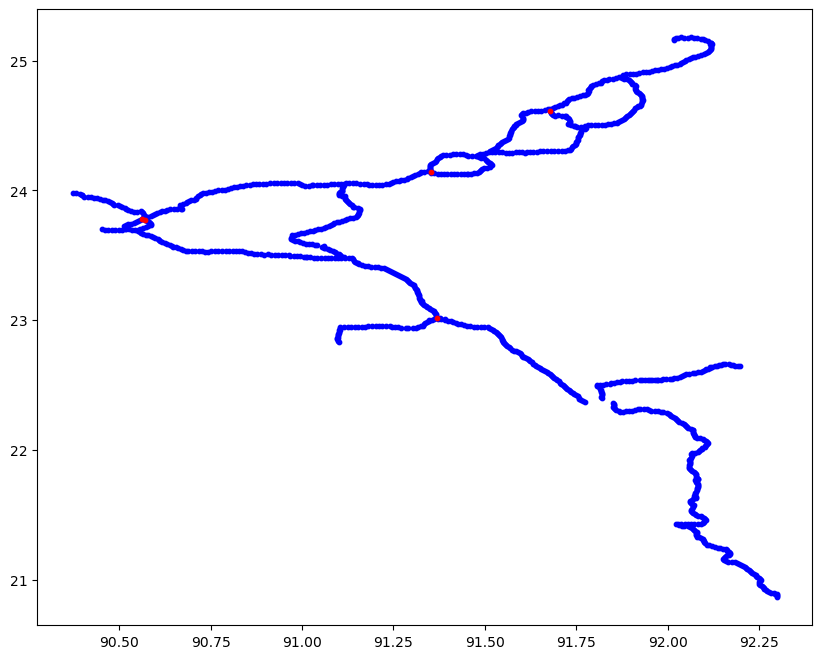

In [87]:
# plot the whole road but assign different color to df_N1_N106
plt.figure(figsize=(10, 8))

plt.scatter(df_1['lon'], df_1['lat'], s=10, c='blue')
plt.scatter(df_single_out['lon'], df_single_out['lat'], s=10, c='red')

plt.show()

In [88]:
df_intersection_2 = df_intersection_2.drop(index=index)

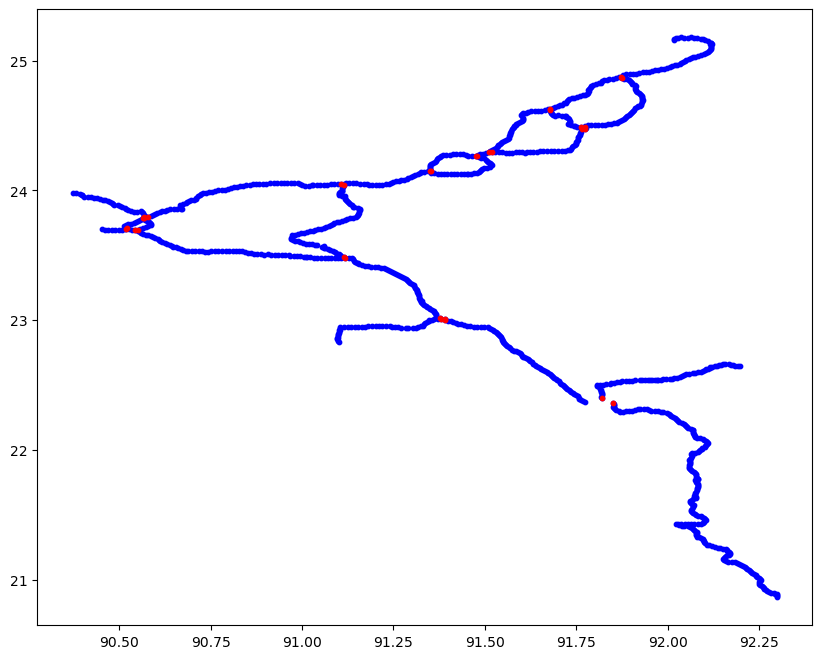

In [89]:
# plot the whole road but assign different color to df_N1_N106
plt.figure(figsize=(10, 8))

plt.scatter(df_1['lon'], df_1['lat'], s=10, c='blue')
plt.scatter(df_intersection_2['lon'], df_intersection_2['lat'], s=10, c='red')

plt.show()

In [90]:
df_intersection_2.shape

(32, 11)

There are 13 intersections.
32/2 = 16, hence 3 of them is false intersections

In [91]:
df_intersection_2

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1818,N2,N2_1,link,Sylhet 230 km,23.706889,90.520472,0.166,NaN,N2LRP001,N1_11,0.237216
11,N1,N1_11,link,"Chittagong 251 km,Comilla 84 km",23.705028,90.519333,0.503,NaN,N1LRP009,N2_1,0.237216
2166,N2,N2_349,link,Sylhet 90 km,24.267249,91.474360,0.227,NaN,N2LRP142,N204_67,0.363083
2638,N204,N204_67,link,Km post missing,24.266556,91.477860,0.710,NaN,N204LRP036,N2_349,0.363083
1280,N104,N104_4,link,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
265,N1,N1_265,link,Km post missing,23.013278,91.376944,1.000,NaN,N1LRP148,N104_4,0.544195
1386,N105,N105_19,link,Information missing,23.789222,90.568805,1.021,NaN,N105LRP013,N2_13,0.550613
1830,N2,N2_13,link,Km post missing,23.784972,90.566028,1.000,NaN,N2LRP012,N105_19,0.550613
2789,N207,N207_135,link,Sylhet 38 km,24.623277,91.678166,0.075,NaN,N207LRP068,N2_539,0.640258
2356,N2,N2_539,link,Sylhet 40 km/ Start of Sylhet road Division / ...,24.629027,91.678499,0.020,NaN,N2LRP192,N207_135,0.640258


In [92]:
 def plot_road_network(df_demo):   
    # Define a color map for different roads
    color_map = plt.cm.get_cmap('tab20', len(df_demo['road'].unique()))

    # Create a scatter plot
    plt.figure(figsize=(10, 8))

    # Plot each road with a different color
    for i, road in enumerate(df_demo['road'].unique()):
        subset = df_demo[(df_demo['road'] == road) & (df_demo['model_type'] == 'link')]
        plt.scatter(subset['lon'], subset['lat'], c=[color_map(i)], label=road, s=10, marker='o')

    # Annotate the first data point of each road with the road name
    for road in df_demo['road'].unique():
        first_point = df_demo[df_demo['road'] == road].iloc[0]
        plt.text(first_point['lon'], first_point['lat'], road, fontsize=9, ha='right')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Network Plot')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_5426/2088389589.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(df_demo['road'].unique()))


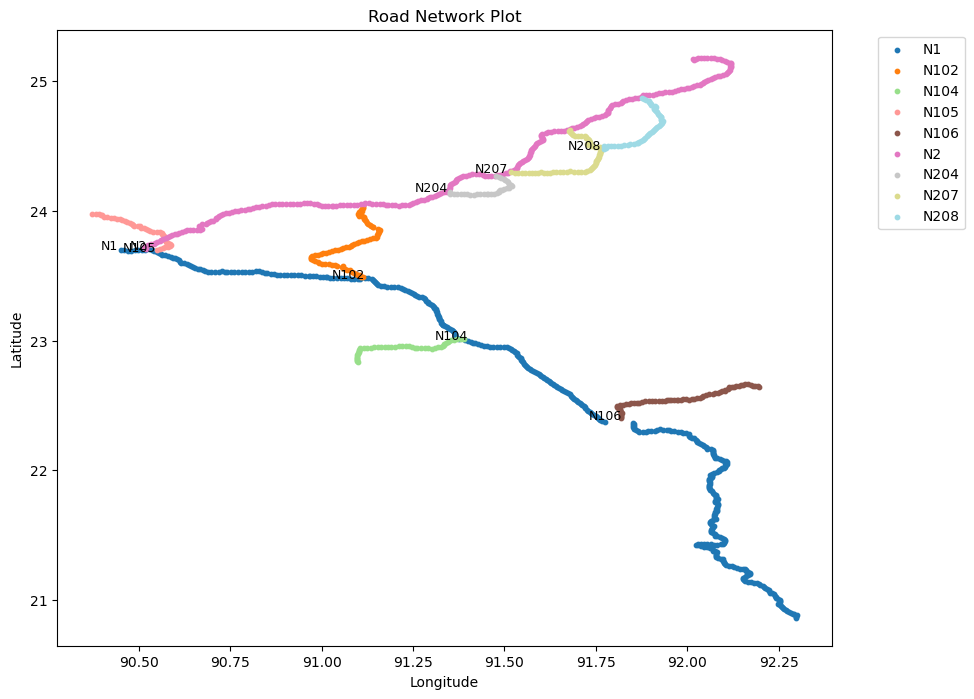

In [93]:
plot_road_network(df_filtered_25)

- n2 n1 1
- n2 n204 1
- n104 n1 1 F 
- n105 n2 1 F
- n207 n2 1
- n2 n204 2
- n104 n1 2 F
- n2 n207 2
- n208 n207 1 F
- n2 n208 1
- n1 n102 1
- n102 n2 1
- n1 n105 1
- n105 n2 2 F
- n208 n207 2 F
- n106 n1 1

F = one of them is false

In [94]:
index_false = [1280, 265, #N104 N1 A
               1386, 1830, #N105 N2 B
               1279, 267, #N104 N1 A
               2794, 2748, #N208 N207 C
               1387, 1834, #N105 N2 B
               2798, 2751] #N208 N207 C
df_intersection_2.loc[index_false]

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1280,N104,N104_4,link,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
265,N1,N1_265,link,Km post missing,23.013278,91.376944,1.000,NaN,N1LRP148,N104_4,0.544195
1386,N105,N105_19,link,Information missing,23.789222,90.568805,1.021,NaN,N105LRP013,N2_13,0.550613
1830,N2,N2_13,link,Km post missing,23.784972,90.566028,1.000,NaN,N2LRP012,N105_19,0.550613
1279,N104,N104_3,link,Km post missing,23.009306,91.389805,0.583,NaN,N104LRP001,N1_267,0.856249
267,N1,N1_267,link,Ctg 95 km,23.001889,91.392055,1.877,NaN,N1LRP150,N104_3,0.856249
2794,N208,N208_3,link,Km post missing,24.475722,91.772777,0.093,NaN,N208LRP001,N207_94,0.884147
2748,N207,N207_94,link,Sylhet 63 km,24.471360,91.765472,0.320,NaN,N207LRP043,N208_3,0.884147
1387,N105,N105_20,link,Km Post missing,23.798694,90.568722,1.000,NaN,N105LRP014,N2_17,1.149343
1834,N2,N2_17,link,Km post missing,23.796694,90.579805,1.000,NaN,N2LRP014,N105_20,1.149343


Choose one from the pairs above based on the smallest distance

In [95]:
index_drop = [1279, 267,
              1387, 1834,
              2798, 2751]
df_intersection_3 = df_intersection_2.drop(index=index_drop)

In [96]:
df_intersection_3.shape

(26, 11)

In [97]:
df_intersection_3

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1818,N2,N2_1,link,Sylhet 230 km,23.706889,90.520472,0.166,NaN,N2LRP001,N1_11,0.237216
11,N1,N1_11,link,"Chittagong 251 km,Comilla 84 km",23.705028,90.519333,0.503,NaN,N1LRP009,N2_1,0.237216
2166,N2,N2_349,link,Sylhet 90 km,24.267249,91.474360,0.227,NaN,N2LRP142,N204_67,0.363083
2638,N204,N204_67,link,Km post missing,24.266556,91.477860,0.710,NaN,N204LRP036,N2_349,0.363083
1280,N104,N104_4,link,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
265,N1,N1_265,link,Km post missing,23.013278,91.376944,1.000,NaN,N1LRP148,N104_4,0.544195
1386,N105,N105_19,link,Information missing,23.789222,90.568805,1.021,NaN,N105LRP013,N2_13,0.550613
1830,N2,N2_13,link,Km post missing,23.784972,90.566028,1.000,NaN,N2LRP012,N105_19,0.550613
2789,N207,N207_135,link,Sylhet 38 km,24.623277,91.678166,0.075,NaN,N207LRP068,N2_539,0.640258
2356,N2,N2_539,link,Sylhet 40 km/ Start of Sylhet road Division / ...,24.629027,91.678499,0.020,NaN,N2LRP192,N207_135,0.640258


In [98]:
df_intersection_3['model_type'].value_counts()

model_type
link    26
Name: count, dtype: int64

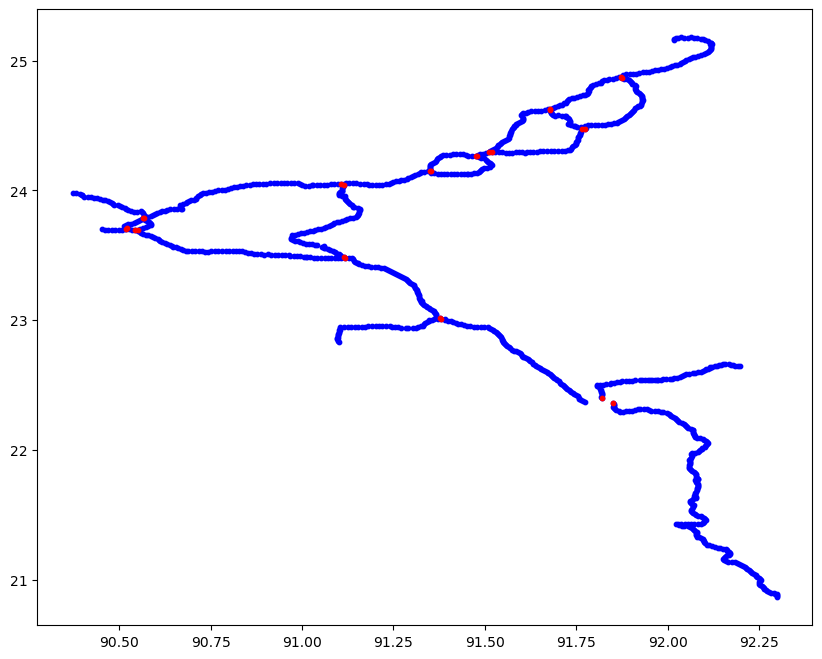

In [99]:
plt.figure(figsize=(10, 8))

plt.scatter(df_1['lon'], df_1['lat'], s=10, c='blue')
plt.scatter(df_intersection_3['lon'], df_intersection_3['lat'], s=10, c='red')

plt.show()

In [100]:
df_intersection_4 = df_intersection_3.copy()

In [101]:
# group by distance_to_nearest_road, if the length of the group is greater is 2:
# replace the lat lon of the second row with the same lat lon of the first row
for _, group in df_intersection_4.groupby('distance_to_nearest_road'):
    if len(group) == 2:
        lat = group.iloc[0]['lat']
        lon = group.iloc[0]['lon']
        df_intersection_4.loc[group.index[1], 'lat'] = lat
        df_intersection_4.loc[group.index[1], 'lon'] = lon

In [102]:
df_intersection_4

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1818,N2,N2_1,link,Sylhet 230 km,23.706889,90.520472,0.166,NaN,N2LRP001,N1_11,0.237216
11,N1,N1_11,link,"Chittagong 251 km,Comilla 84 km",23.706889,90.520472,0.503,NaN,N1LRP009,N2_1,0.237216
2166,N2,N2_349,link,Sylhet 90 km,24.267249,91.474360,0.227,NaN,N2LRP142,N204_67,0.363083
2638,N204,N204_67,link,Km post missing,24.267249,91.474360,0.710,NaN,N204LRP036,N2_349,0.363083
1280,N104,N104_4,link,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
265,N1,N1_265,link,Km post missing,23.009528,91.380360,1.000,NaN,N1LRP148,N104_4,0.544195
1386,N105,N105_19,link,Information missing,23.789222,90.568805,1.021,NaN,N105LRP013,N2_13,0.550613
1830,N2,N2_13,link,Km post missing,23.789222,90.568805,1.000,NaN,N2LRP012,N105_19,0.550613
2789,N207,N207_135,link,Sylhet 38 km,24.623277,91.678166,0.075,NaN,N207LRP068,N2_539,0.640258
2356,N2,N2_539,link,Sylhet 40 km/ Start of Sylhet road Division / ...,24.623277,91.678166,0.020,NaN,N2LRP192,N207_135,0.640258


In [103]:
df_intersection_4['model_type'] = 'intersection'

In [104]:
df_intersection_4

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1818,N2,N2_1,intersection,Sylhet 230 km,23.706889,90.520472,0.166,NaN,N2LRP001,N1_11,0.237216
11,N1,N1_11,intersection,"Chittagong 251 km,Comilla 84 km",23.706889,90.520472,0.503,NaN,N1LRP009,N2_1,0.237216
2166,N2,N2_349,intersection,Sylhet 90 km,24.267249,91.474360,0.227,NaN,N2LRP142,N204_67,0.363083
2638,N204,N204_67,intersection,Km post missing,24.267249,91.474360,0.710,NaN,N204LRP036,N2_349,0.363083
1280,N104,N104_4,intersection,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
265,N1,N1_265,intersection,Km post missing,23.009528,91.380360,1.000,NaN,N1LRP148,N104_4,0.544195
1386,N105,N105_19,intersection,Information missing,23.789222,90.568805,1.021,NaN,N105LRP013,N2_13,0.550613
1830,N2,N2_13,intersection,Km post missing,23.789222,90.568805,1.000,NaN,N2LRP012,N105_19,0.550613
2789,N207,N207_135,intersection,Sylhet 38 km,24.623277,91.678166,0.075,NaN,N207LRP068,N2_539,0.640258
2356,N2,N2_539,intersection,Sylhet 40 km/ Start of Sylhet road Division / ...,24.623277,91.678166,0.020,NaN,N2LRP192,N207_135,0.640258


In [105]:
# group by distance_to_nearest_road, assign the same new id to the pair of rows id1 + id2
for _, group in df_intersection_4.groupby('distance_to_nearest_road'):
    if len(group) == 2:
        new_id = group.iloc[0]['id'] + group.iloc[1]['id']
        df_intersection_4.loc[group.index, 'id'] = new_id

In [106]:
df_intersection_4

,road,id,model_type,name,lat,lon,length,condition,road_lrp,nearest_road,distance_to_nearest_road
1818,N2,N2_1N1_11,intersection,Sylhet 230 km,23.706889,90.520472,0.166,NaN,N2LRP001,N1_11,0.237216
11,N1,N2_1N1_11,intersection,"Chittagong 251 km,Comilla 84 km",23.706889,90.520472,0.503,NaN,N1LRP009,N2_1,0.237216
2166,N2,N2_349N204_67,intersection,Sylhet 90 km,24.267249,91.474360,0.227,NaN,N2LRP142,N204_67,0.363083
2638,N204,N2_349N204_67,intersection,Km post missing,24.267249,91.474360,0.710,NaN,N204LRP036,N2_349,0.363083
1280,N104,N104_4N1_265,intersection,Km post missing,23.009528,91.380360,1.000,NaN,N104LRP002,N1_265,0.544195
265,N1,N104_4N1_265,intersection,Km post missing,23.009528,91.380360,1.000,NaN,N1LRP148,N104_4,0.544195
1386,N105,N105_19N2_13,intersection,Information missing,23.789222,90.568805,1.021,NaN,N105LRP013,N2_13,0.550613
1830,N2,N105_19N2_13,intersection,Km post missing,23.789222,90.568805,1.000,NaN,N2LRP012,N105_19,0.550613
2789,N207,N207_135N2_539,intersection,Sylhet 38 km,24.623277,91.678166,0.075,NaN,N207LRP068,N2_539,0.640258
2356,N2,N207_135N2_539,intersection,Sylhet 40 km/ Start of Sylhet road Division / ...,24.623277,91.678166,0.020,NaN,N2LRP192,N207_135,0.640258


In [107]:
intersection_to_merge = df_intersection_4.drop(columns=['nearest_road', 'distance_to_nearest_road'])

In [ ]:
# replace the rows in df_filtered_25_links with the rows in intersection_to_merge
df_filtered_25.loc[df_intersection_4.index] = intersection_to_merge

In [110]:
df_filtered_25['model_type'].value_counts()

model_type
bridge          1559
link            1125
intersection      26
sourcesink        18
Name: count, dtype: int64

## 8. Save demo file as a csv

In [107]:
df_demo = df_filtered_25.copy()

In [ ]:
# save the df_demo dataframe to a csv file
dir = '../data/processed/'
filename = 'demo_with_intersection.csv'
df_demo.to_csv(dir + filename, index=False)

## 9. Plot roads

### Plot different components

In [109]:
def plot_network(df_demo):
    # Define colors and markers for each model type
    colors = {
        'bridge': 'yellow',
        'link': 'blue',
        'sourcesink': 'cyan',
        'intersection': 'red'
    }

    markers = {
        'bridge': 'x',
        'link': 'o',
        'sourcesink': 's',
        'intersection': '*'
    }

    marker_sizes = {
        'bridge': 60,
        'link': 10,
        'sourcesink': 30,
        'intersection': 20
    }

    # Create a scatter plot
    plt.figure(figsize=(10, 8))

    for model_type, color in colors.items():
        subset = df_demo[df_demo['model_type'] == model_type]
        plt.scatter(subset['lon'], subset['lat'], c=color, label=model_type, s=marker_sizes[model_type], marker=markers[model_type])

    # Annotate the first data point of each road with the road name
    for road in df_demo['road'].unique():
        first_point = df_demo[df_demo['road'] == road].iloc[0]
        plt.text(first_point['lon'], first_point['lat'], road, fontsize=9, ha='right')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Network Plot')
    plt.legend()
    plt.show()

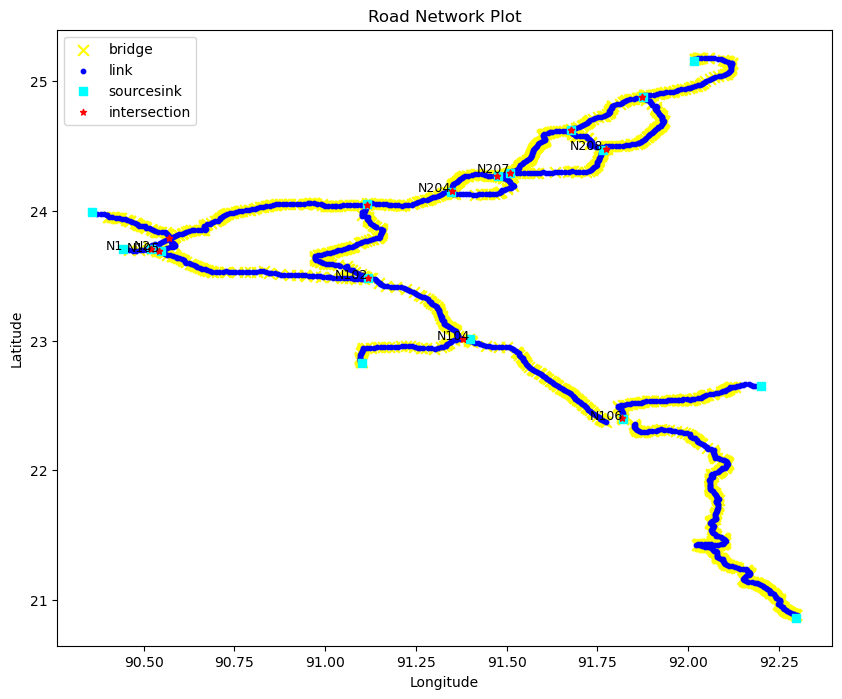

In [112]:
plot_network(df_filtered_25)

### Plot different roads

/var/folders/mf/ky9ttxzd0z318clhb4j11v_80000gn/T/ipykernel_31047/708589594.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(df_demo['road'].unique()))


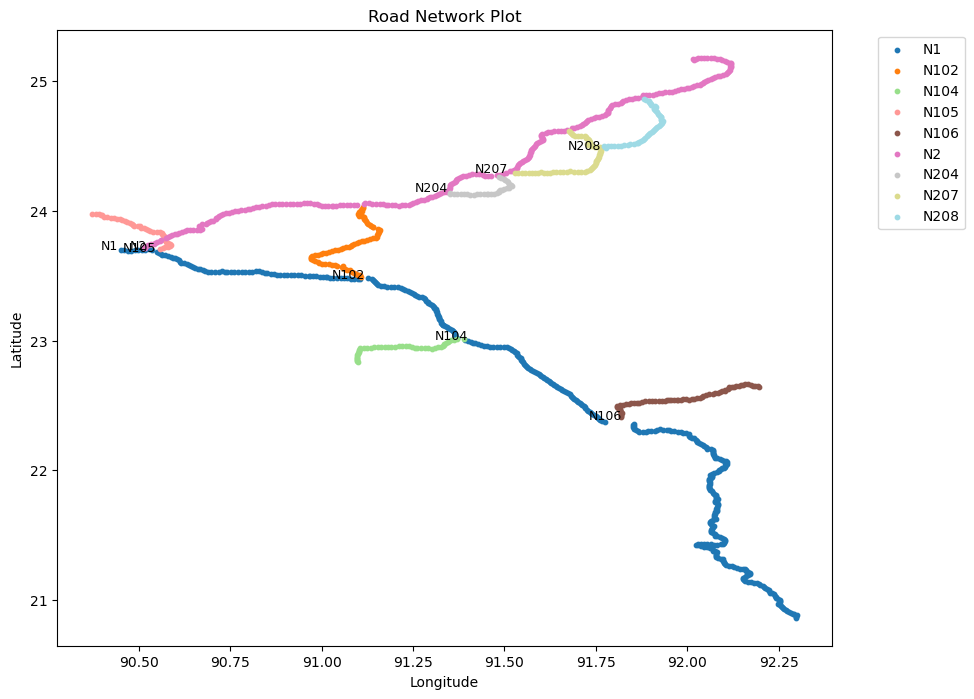

In [111]:
import matplotlib.pyplot as plt

# Define a color map for different roads
color_map = plt.cm.get_cmap('tab20', len(df_demo['road'].unique()))

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Plot each road with a different color
for i, road in enumerate(df_demo['road'].unique()):
    subset = df_demo[(df_demo['road'] == road) & (df_demo['model_type'] == 'link')]
    plt.scatter(subset['lon'], subset['lat'], c=[color_map(i)], label=road, s=10, marker='o')

# Annotate the first data point of each road with the road name
for road in df_demo['road'].unique():
    first_point = df_demo[df_demo['road'] == road].iloc[0]
    plt.text(first_point['lon'], first_point['lat'], road, fontsize=9, ha='right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network Plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
